In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pygame
import time
import gymnasium as gym
from gymnasium.spaces import Dict, Discrete, Box
from collections import OrderedDict


# env tests

In [106]:
import numpy as np

def bounding_rectangle(vertices):
    """
    Computes the bounding rectangle for a quadrilateral.
    
    Parameters:
        vertices (list of tuples): Vertices of the quadrilateral.
    
    Returns:
        list of tuples: Vertices of the bounding rectangle.
    """
    x_coords = [v[0] for v in vertices]
    y_coords = [v[1] for v in vertices]
    xmin, xmax = min(x_coords), max(x_coords)
    ymin, ymax = min(y_coords), max(y_coords)
    
    return [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]

def is_point_in_triangle(point, triangle):
    """
    Check if a point is inside a triangle using barycentric coordinates.
    
    Args:
        point (tuple): (x, y) coordinates of the point to check
        triangle (list): List of 3 tuples, each representing vertex coordinates [(x1,y1), (x2,y2), (x3,y3)]
    
    Returns:
        bool: True if point is inside the triangle, False otherwise
    """
    def compute_barycentric_coordinates(pt, v1, v2, v3):
        """
        Compute barycentric coordinates of a point with respect to a triangle.
        
        Args:
            pt (tuple): Point coordinates
            v1, v2, v3 (tuple): Vertex coordinates of the triangle
        
        Returns:
            tuple: Barycentric coordinates (u, v, w)
        """
        pt = np.array(pt)
        v1, v2, v3 = np.array(v1), np.array(v2), np.array(v3)
        
        # Vectorized area computation
        triangle_area = np.abs(np.cross(v2 - v1, v3 - v1)) / 2
        
        # Areas of sub-triangles
        area1 = np.abs(np.cross(pt - v2, v3 - v2)) / 2
        area2 = np.abs(np.cross(v1 - pt, v3 - v1)) / 2
        area3 = np.abs(np.cross(v1 - v2, pt - v2)) / 2
        
        # Compute barycentric coordinates
        u = area1 / triangle_area
        v = area2 / triangle_area
        w = area3 / triangle_area
        
        return u, v, w
    
    # Compute barycentric coordinates
    u, v, w = compute_barycentric_coordinates(point, triangle[0], triangle[1], triangle[2])
    
    # Point is inside if all barycentric coordinates are between 0 and 1 (inclusive)
    return 0 <= u <= 1 and 0 <= v <= 1 and 0 <= w <= 1 and np.abs(u + v + w - 1) < 1e-10

def is_point_in_parallelogram(point, box):
    """
    Check if a point is inside a parallelogram.
    
    Args:
        point (tuple): (x, y) coordinates of the point to check
        box (list): List of 4 tuples, each representing vertex coordinates [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
    
    Returns:
        bool: True if point is inside the parallelogram, False otherwise
    """
    # Check if the point is in one of the two triangles of the parallelogram
    return is_point_in_triangle(point, [box[0], box[1], box[2]]) or is_point_in_triangle(point, [box[0], box[2], box[3]])

def sample_in_parallelogram(box):
    """
    Sample a point uniformly inside a parallelogram.
    
    Args:
        box (list): List of 4 tuples, each representing vertex coordinates [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
    
    Returns:
        tuple: (x, y) coordinates of the sampled point
    """

    # Compute bounding box
    rect = bounding_rectangle(box)
    x_min, y_min = rect[0]
    x_max, y_max = rect[2]    
    # Keep sampling until a point inside the parallelogram is found

    x = np.random.uniform(x_min, x_max)
    y = np.random.uniform(y_min, y_max)
    while not is_point_in_parallelogram((x, y), box):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
    
    return [x, y]

Point: [0.001614156444358139, 0.3787840343908575]
Box: [array([0., 0.]), array([ 0.88636285, -0.16401583]), array([1.07230681, 0.48141086]), array([0.18594396, 0.64542669])]
False


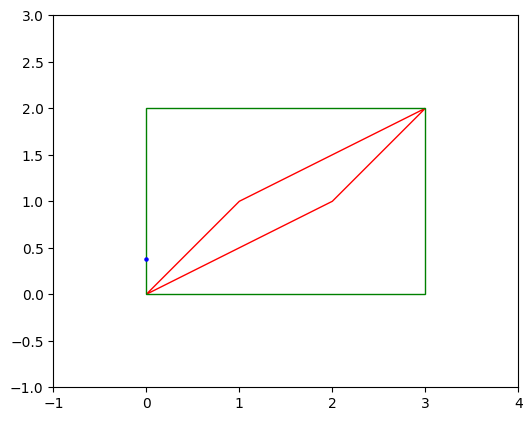

In [144]:
point = env.state
box = env.transformed_corners

print("Point:", point)
print("Box:", box)

print(is_point_in_parallelogram(point, box))

# sample 100 points in the parallelogram and plot them along with the parallelogram
box = [(0, 0), (2, 1), (3, 2), (1, 1)]
rectangle = bounding_rectangle(box)
points = np.array(point)
plt.figure(figsize=(6, 6))
plt.gca().add_patch(patches.Polygon(box, fill=None, edgecolor='r'))
plt.gca().add_patch(patches.Polygon(rectangle, fill=None, edgecolor='g'))
plt.scatter(points[0], points[1], c='b', s=5)
plt.xlim(-1, 4)
plt.ylim(-1, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [176]:
class ObservableDeformedGridworld(gym.Env):

    def __init__(self, grid_size=(1.0, 1.0), step_size=0.02, goal=(0.9, 0.9), 
                 obstacles=None, stretch=(1.0, 1.0), shear=(0.0, 0.0), observation_radius=0.05, render_mode=None):
        """
        Initialize the observable deformed continuous gridworld.
        :param grid_size: Size of the grid (width, height).
        :param step_size: Step size for the agent's movement.
        :param goal: Coordinates of the goal position.
        :param obstacles: List of obstacles as rectangles [(x_min, y_min), (x_max, y_max)].
        :param stretch: Tuple (s_x, s_y) for stretching the grid in x and y directions.
        :param shear: Tuple (sh_x, sh_y) for shearing the grid.
        :param observation_radius: Radius within which the agent can observe its surroundings.
        """
        self.grid_size = np.array(grid_size)
        self.step_size = step_size
        self.goal = np.array(goal)
        self.state = np.array([0.1, 0.1])  # Start at the origin
        self.obstacles = obstacles if obstacles else []
        self.observation_radius = observation_radius

        # Transformation matrix
        self.transformation_matrix = np.array([
            [stretch[0], shear[0]],
            [shear[1], stretch[1]]
        ])
        self.inverse_transformation_matrix = np.linalg.inv(self.transformation_matrix)

        # Rendering mode
        self.render_mode = render_mode

        # gymnasium compatibility
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space =  Dict({
            "pos": gym.spaces.Box(low=.0, high=1.0, shape=(2,),dtype=float),
            "theta": gym.spaces.Box(low=.0, high=1.0, shape=(4,),dtype=float), # deformation is a 2x2 tensor
            # "obs": gym.spaces.Box(low=0, high=1, shape=(4,),dtype=int),
        })

        self.stretch_range = np.array([0.4, 1])
        self.shear_range = np.array([-0.2, 0.2])

        self.timestep = 0

        self.corners = [
            np.array([0, 0]),
            np.array([self.grid_size[0], 0]),
            self.grid_size,
            np.array([0, self.grid_size[1]]),
        ]
        self.transformed_corners = [self.transform(corner) for corner in self.corners]
        
    def reset(self,seed=None):
        """
        Reset the environment to the initial state.
        :return: Initial state and observation.
        """
        np.random.seed(seed)
        self.set_deformation(self.sample(2,self.stretch_range), self.sample(2,self.shear_range))  # Reset deformation to random
        self.transformed_corners = [self.transform(corner) for corner in self.corners]
        # self.state = np.array([0.1, 0.1])  # Start at the origin
        #self.state = np.random.rand(2) * self.transform(self.grid_size) # Random start position in the deformable grid
        self.state = sample_in_parallelogram(self.transformed_corners)


        state = OrderedDict({
            "pos": self.state,
            "theta": self.transformation_matrix.flatten(),
            # "obs": self.observe_obstacle()
        }) 
        
        self.timestep = 0

        # print(f"Initial agent position: {self.state}",
        #       f"Initial goal position: {self.goal}",
        #       f"Initial deformation: {self.transformation_matrix}",
        #       f"Initial observation: {self.observe_obstacle()}",
        #       sep="\n")
        
        return state, {}
    
    def set_deformation(self, stretch, shear):
        """
        Set the deformation transformation matrix based on stretch and shear parameters.
        
        This function creates a transformation matrix to apply grid deformations, including 
        stretching and shearing, to the grid coordinates. It also computes the inverse of 
        this transformation for reversing the deformation.

        :param stretch: A tuple (s_x, s_y) for stretching the grid in the x and y directions.
        :param shear: A tuple (sh_x, sh_y) for shearing the grid in the x and y directions.
        """
        # Create the transformation matrix based on stretch and shear
        self.transformation_matrix = np.array([
            [stretch[0], shear[0]],  # First row: stretch in x and shear in x direction
            [shear[1], stretch[1]]   # Second row: shear in y and stretch in y direction
        ])

        # Calculate the inverse transformation matrix for reversing the deformation
        self.inverse_transformation_matrix = np.linalg.inv(self.transformation_matrix)

        # Optionally, print the transformation matrices for debugging
        # print(f"Transformation Matrix:\n{self.transformation_matrix}")
        # print(f"Inverse Transformation Matrix:\n{self.inverse_transformation_matrix}")

    def set_pos(self, pos):
        """
        Set the agent's state to a new position.
        
        This function directly updates the agent's position (state) to the provided coordinates.

        :param pos: A tuple or array representing the new position of the agent in the grid.
        """
        # Update the state (agent's position)
        self.state = np.array(pos)

        # Optionally, print the new state for debugging
        # print(f"New agent position: {self.state}")

    def transform(self, position):
        """
        Apply the grid deformation to a given position.
        :param position: (x, y) in original space.
        :return: Transformed position in the deformed grid.
        """
        return np.dot(self.transformation_matrix, position)

    def inverse_transform(self, position):
        """
        Map a position from the deformed grid back to the original space.
        :param position: (x, y) in the deformed grid.
        :return: Original position.
        """
        return np.dot(self.inverse_transformation_matrix, position)

    def is_in_obstacle(self, position):
        """
        Check if a given position is inside any obstacle.
        :param position: The (x, y) coordinates to check in the original space.
        :return: True if the position is inside an obstacle, False otherwise.
        """
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            x_min_transformed, y_min_transformed = self.transform([x_min, y_min])
            x_max_transformed, y_max_transformed = self.transform([x_max, y_max])
            if x_min_transformed <= position[0] <= x_max_transformed and y_min_transformed <= position[1] <= y_max_transformed:
                return True
        return False

    def observe_single_obstacle(self):
        """
        Check if any part of an obstacle is within the observation radius of the agent.
        :return: True if any part of an obstacle is within the observation radius, False otherwise.
        """
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            
            # Clamp the agent's position to the obstacle's boundaries to find the closest point
            closest_x = np.clip(self.state[0], x_min, x_max)
            closest_y = np.clip(self.state[1], y_min, y_max)
            
            # Compute the distance from the agent to this closest point
            closest_point = np.array([closest_x, closest_y])
            distance_to_obstacle = np.linalg.norm(self.state - closest_point)
            
            # Check if this distance is within the observation radius
            if distance_to_obstacle <= self.observation_radius:
                return 1
        
        return 0
    
    def observe_obstacle(self):
        """
        Efficiently and precisely check for obstacles in the four cardinal directions (N, E, S, W).
        Each direction checks for obstacles in a quarter-circle arc within the observation radius.
        :return: A numpy array of shape (4,), where each entry indicates the presence of obstacles 
                in the respective direction (North, East, South, West).
        """
        directions = ["N", "E", "S", "W"]
        obstacle_presence = np.zeros(4)  # Default: no obstacles in any direction

        # Precompute direction boundaries in radians
        direction_ranges = [
            (315, 45),   # North: [-45°, +45°]
            (45, 135),   # East: [+45°, +135°]
            (135, 225),  # South: [+135°, +225°]
            (225, 315)   # West: [+225°, +315°]
        ]
        direction_ranges_rad = [(np.deg2rad(a1), np.deg2rad(a2)) for a1, a2 in direction_ranges]

        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            x_min, y_min = self.transform([x_min, y_min])
            x_max, y_max = self.transform([x_max, y_max])

            # Generate sampled points along the edges of the obstacle
            num_samples = 5  # Increase for more precision
            edge_points = np.concatenate([
                np.linspace([x_min, y_min], [x_max, y_min], num_samples),  # Bottom edge
                np.linspace([x_max, y_min], [x_max, y_max], num_samples),  # Right edge
                np.linspace([x_max, y_max], [x_min, y_max], num_samples),  # Top edge
                np.linspace([x_min, y_max], [x_min, y_min], num_samples)   # Left edge
            ])

            # Compute vectors from agent to sampled points
            vectors = edge_points - self.state
            distances = np.linalg.norm(vectors, axis=1)

            # Filter points that are outside the observation radius
            within_radius = distances <= self.observation_radius
            if not np.any(within_radius):
                continue  # Skip obstacles entirely outside the radius

            # Compute angles relative to positive Y-axis
            angles = np.arctan2(vectors[:, 1], vectors[:, 0])  # Radians
            angles = (angles + 2 * np.pi) % (2 * np.pi)  # Normalize to [0, 2π)

            # Check which direction each point falls into
            for i, (angle_min, angle_max) in enumerate(direction_ranges_rad):
                if obstacle_presence[i] == 1:
                    continue  # Early exit if the direction is already flagged
                for angle in angles[within_radius]:
                    if (angle_min <= angle < angle_max) or (
                        angle_max < angle_min and (angle >= angle_min or angle < angle_max)
                    ):
                        obstacle_presence[i] = 1
                        break  # No need to check further points for this direction

        return obstacle_presence
        
    def step(self, action):
        """
        Take a step in the environment, interpreting the action in the deformed space.
        :param action: One of ['N', 'S', 'E', 'W'].
        :return: Tuple (next_state, observation, reward, done, info).
        """
        # Map actions to movements in the deformed space
        moves = [np.array([0, self.step_size]),   # Move up in deformed space
            np.array([0, -self.step_size]),  # Move down in deformed space
            np.array([self.step_size, 0]),   # Move right in deformed space
            np.array([-self.step_size, 0])   # Move left in deformed space
        ]

        # Get the movement vector in the deformed space
        move = moves[action]

        # Map the movement to the original space using the inverse transformation
        # move_original = np.dot(self.inverse_transformation_matrix, move)

        # Update state in the original grid space
        next_state = self.state + move

        num_samples = 10  # Number of points to sample along the path
        path = np.linspace(self.state, next_state, num_samples)

        # Check for collisions along the path
        collision = any(self.is_in_obstacle(point) for point in path)

        # Check if the new state is in an obstacle
        if collision:
            reward = -2.0  # Penalty for hitting an obstacle
            info = {"collision": True}
            terminated = False
        # Check if the is inside the deformed grid boundaries
        elif not is_point_in_parallelogram(next_state, self.transformed_corners):
            reward = -2.0
            info = {"out": True}
            next_state = self.state
            terminated = False
        else:   
            transformed_goal = self.transform(self.goal)
            terminated = np.linalg.norm(next_state - transformed_goal) < self.step_size
            reward = 1.0 if terminated else -0.5
            info = {"collision": False, "out": False}
    
        self.state = next_state
        self.timestep += 1
        truncated = self.timestep > 200 

        if self.render_mode == "human":
            self.render()

        state = OrderedDict({
                    "pos": self.state,
                    "theta": self.transformation_matrix.flatten(),
                    # "obs": self.observe_obstacle()
                })

        # Return the transformed state, reward, and terminated truncated flag
        return state, reward, terminated, truncated, info

    def render_old(self):
        """
        Render the deformed gridworld environment using Pygame, ensuring the entire deformed grid fits within the screen.
        """
        import pygame  # Ensure Pygame is imported

        # Define colors
        WHITE = (255, 255, 255)
        BLUE = (0, 0, 255)
        GREEN = (0, 255, 0)
        RED = (255, 0, 0)
        YELLOW = (255, 255, 0)
        BLACK = (0, 0, 0)

        # Initialize the screen
        if not hasattr(self, "screen"):
            self.screen_width = 800
            self.screen_height = 600
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            pygame.display.set_caption("Deformed Gridworld Environment")

        # Fill background with white
        self.screen.fill(WHITE)

        # Compute the bounding box of the deformed grid
        corners = [
            self.transform(np.array([0, 0])),
            self.transform(np.array([self.grid_size[0], 0])),
            self.transform(self.grid_size),
            self.transform(np.array([0, self.grid_size[1]])),
        ]
        x_coords, y_coords = zip(*corners)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        # Define scaling factors to fit the deformed grid within the screen
        scale_x = self.screen_width / (max_x - min_x)
        scale_y = self.screen_height / (max_y - min_y)
        scale = min(scale_x, scale_y)  # Uniform scaling to maintain aspect ratio

        # Transform helper for rendering
        def to_screen_coords(pos):
            """
            Map transformed coordinates to screen coordinates, scaled and shifted to fit the screen.
            """
            x, y = pos
            x_screen = int((x - min_x) * scale)
            y_screen = int((max_y - y) * scale)  # Flip y-axis for screen rendering
            return x_screen, y_screen

        # Draw the deformed grid boundaries
        pygame.draw.polygon(self.screen, BLACK, [to_screen_coords(corner) for corner in corners], width=3)

        # Draw the obstacles
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            bottom_left = self.transform(np.array([x_min, y_min]))
            bottom_right = self.transform(np.array([x_max, y_min]))
            top_left = self.transform(np.array([x_min, y_max]))
            top_right = self.transform(np.array([x_max, y_max]))
            
            # Draw each obstacle as a polygon in the deformed space
            pygame.draw.polygon(self.screen, RED, [
                to_screen_coords(bottom_left),
                to_screen_coords(bottom_right),
                to_screen_coords(top_right),
                to_screen_coords(top_left)
            ])

        # Draw the agent
        agent_position = self.transform(self.state)
        pygame.draw.circle(self
        .screen, BLUE, to_screen_coords(agent_position), 10)

        # Draw the goal
        goal_position = self.transform(self.goal)
        pygame.draw.circle(self.screen, GREEN, to_screen_coords(goal_position), 12)

        # Draw observation radius as a dashed circle around the agent
        observation_radius = self.observation_radius * max(self.transformation_matrix.diagonal())
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(agent_position), 
                        int(observation_radius * scale), 1)

        # Update the display
        pygame.display.flip()

        # Handle key events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return
            elif event.type == pygame.KEYDOWN:
                # Press 'r' to reset environment
                if event.key == pygame.K_r:
                    self.reset()
                # Press 'w' to quit
                elif event.key == pygame.K_w:
                    pygame.quit()
                    return
                # Press 's' to save current state
                elif event.key == pygame.K_s:
                    self.save_state()
                # Press space to pause/resume
                elif event.key == pygame.K_SPACE:
                    self.pause()
                # Press arrow keys for manual control
                elif event.key == pygame.K_LEFT:
                    return self.step(3)  # Left action
                elif event.key == pygame.K_RIGHT:
                    return self.step(2)  # Right action
                elif event.key == pygame.K_UP:
                    return self.step(0)  # Up action
                elif event.key == pygame.K_DOWN:
                    return self.step(1)  # Down action
        return None, None, None, None, None
    
    def close(self):
        self.render_mode = None
        pygame.quit()
    
    def sample(self,num,limit):
        low,high = limit
        return low + np.random.rand(num)*(high-low)
    
    def render(self):
        """
        Render the deformed gridworld environment along with the original gridworld.
        The original gridworld serves as a reference background.
        """
        import pygame  # Ensure Pygame is imported

        # Define colors
        WHITE = (255, 255, 255)
        LIGHT_GRAY = (200, 200, 200)
        BLUE = (0, 0, 255)
        GREEN = (0, 255, 0)
        RED = (255, 0, 0)
        PINK = (255, 105, 180)  
        YELLOW = (255, 255, 0)
        BLACK = (0, 0, 0)

        # Initialize the screen
        if not hasattr(self, "screen"):
            self.screen_width = 1000
            self.screen_height = 1000
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            pygame.display.set_caption("Deformed and Original Gridworld")

        # Fill background with white
        self.screen.fill(WHITE)

    # Compute the bounding box of the deformed grid
        corners = [
            np.array([0, 0]),
            np.array([self.grid_size[0], 0]),
            self.grid_size,
            np.array([0, self.grid_size[1]]),
        ]
        transformed_corners = [self.transform(corner) for corner in corners]
        x_coords, y_coords = zip(*transformed_corners)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        # Define scaling factors to fit the deformed grid within the screen
        scale_x = self.screen_width / (max_x - min_x)
        scale_y = self.screen_height / (max_y - min_y)
        scale = min(scale_x, scale_y)  # Uniform scaling to maintain aspect ratio

        # Add upward translation offset
        y_translation = max(0, -min_y * scale)

        # Transform helper for rendering
        def to_screen_coords(pos):
            """
            Map transformed coordinates to screen coordinates, scaled and shifted to fit the screen.
            """
            x, y = pos
            x_screen = int((x - min_x) * scale)
            y_screen = int((max_y - y) * scale + y_translation)  # Flip y-axis and add upward translation
            return x_screen, y_screen
        
        # Draw the un-deformed grid (background)
        for i in range(int(self.grid_size[0]) + 1):
            pygame.draw.line(self.screen, LIGHT_GRAY,
                            to_screen_coords((i, 0)),
                            to_screen_coords((i, self.grid_size[1])), width=1)
        for j in range(int(self.grid_size[1]) + 1):
            pygame.draw.line(self.screen, LIGHT_GRAY,
                            to_screen_coords((0, j)),
                            to_screen_coords((self.grid_size[0], j)), width=1)

        # Draw the deformed grid boundaries
        corners = [
            np.array([0, 0]),
            np.array([self.grid_size[0], 0]),
            self.grid_size,
            np.array([0, self.grid_size[1]]),
        ]
        transformed_corners = [self.transform(corner) for corner in corners]
        pygame.draw.polygon(self.screen, BLACK, [to_screen_coords(corner) for corner in transformed_corners], width=3)

        # Draw the obstacles in both grids
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            # Original obstacle
            pygame.draw.rect(self.screen, PINK,
                            (*to_screen_coords((x_min, y_max)),  # Top-left corner
                            int((x_max - x_min) * scale),      # Width
                            int((y_max - y_min) * scale)),    # Height
                            width=0)

            # Transformed obstacle
            bottom_left = self.transform(np.array([x_min, y_min]))
            bottom_right = self.transform(np.array([x_max, y_min]))
            top_left = self.transform(np.array([x_min, y_max]))
            top_right = self.transform(np.array([x_max, y_max]))
            pygame.draw.polygon(self.screen, RED, [
                to_screen_coords(bottom_left),
                to_screen_coords(bottom_right),
                to_screen_coords(top_right),
                to_screen_coords(top_left)
            ])

        # Draw the agent in both grids
        agent_position = self.state
        transformed_agent_position = agent_position
        pygame.draw.circle(self.screen, BLUE, to_screen_coords(agent_position), 10)  # Original
        pygame.draw.circle(self.screen, GREEN, to_screen_coords(transformed_agent_position), 10)  # Transformed

        # Draw the goal in both grids
        goal_position = self.goal
        transformed_goal_position = self.transform(goal_position)
        pygame.draw.circle(self.screen, GREEN, to_screen_coords(goal_position), 12)  # Original
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(transformed_goal_position), 12)  # Transformed

        # Draw observation radius as a dashed circle around the agent
        observation_radius = self.observation_radius # stays the same in both grids
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(agent_position), 
                        int(self.observation_radius * scale), 1)  # Original
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(transformed_agent_position), 
                        int(observation_radius * scale), 1)  # Transformed

        # Update the display
        pygame.display.flip()

        # Handle key events
        # Handle key events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return
            elif event.type == pygame.KEYDOWN:
                # Press 'r' to reset environment
                if event.key == pygame.K_r:
                    self.reset()
                # Press 'w' to quit
                elif event.key == pygame.K_w:
                    pygame.quit()
                    return
                # Press 's' to save current state
                elif event.key == pygame.K_s:
                    self.save_state()
                # Press space to pause/resume
                elif event.key == pygame.K_SPACE:
                    self.pause()
                # Press arrow keys for manual control
                elif event.key == pygame.K_LEFT:
                    return self.step(3)  # Left action
                elif event.key == pygame.K_RIGHT:
                    return self.step(2)  # Right action
                elif event.key == pygame.K_UP:
                    return self.step(0)  # Up action
                elif event.key == pygame.K_DOWN:
                    return self.step(1)  # Down action
        return None, None, None, None, None


In [178]:
obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), ((0.0, 0.00125), (0.01625, 0.99125)), ((0.0075, 0.00125), (0.99875, 0.04)), ((0.98875, 0.0075), (0.99875, 1.0)), ((0.00125, 0.9825), (0.99875, 1.0))]

# Example Usage
# obstacles = [
#     [(0.2, 0.2), (0.6, 0.6)],  # Obstacle 1
#     [(0.6, 0.6), (0.8, 0.8)]   # Obstacle 2
# ]

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(1, 1),
    shear=(.0, .0),
    render_mode="human"
)

state, observation = env.reset(np.random.randint(100))
#   
# env.reset(seed=np.random.randint(1078890))
done = False
while not done:
    try:
        _, reward, terminated, truncated, _ = env.render()
        if terminated or truncated:
            print(reward)
            env.close()
            break
    except:
        break



# train

In [ ]:
from stable_baselines3 import DQN
import numpy as np

obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]


def train_dqn(args):
    from stable_baselines3.common.callbacks import CheckpointCallback
    from wandb.integration.sb3 import WandbCallback
    import wandb

    total_timesteps = args.total_timesteps
    batch_size = args.batch_size
    lr = args.learning_rate
    target_update = args.target_update
    gamma = args.gamma

    config = {
        "policy_type": "MultiInputPolicy",
        "env_name": "ObservableDeformedGridworld",
        "total_timesteps": total_timesteps,
        "Batch_Size": batch_size,
        'grid_size': (1.0,1.0),
        'step_size': 0.1,
        'obstacles':obstacles,
        'observation_radius':0.2,
    }
    run = wandb.init(
        project="DQNsb3 - MDP - ObservableDeformedGridworld",
        config=config,
        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
        monitor_gym=True,  # auto-upload the videos of agents playing the game
        save_code=True,  # optional
    )


    # Save a checkpoint every 10000 steps
    checkpoint_callback = CheckpointCallback(
                            save_freq=10000,
                            save_path=f"DQNsb3_{run.id}",
                            name_prefix="rl_model",
                            save_replay_buffer=False,
                            save_vecnormalize=True,
                        )

    callbacks = [ WandbCallback(
                                verbose=2,
                                log="parameters",
                                ),
                checkpoint_callback,
                ]


    from stable_baselines3.common.monitor import Monitor
    from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

    def make_env():
        env = ObservableDeformedGridworld(
            grid_size=(1.0, 1.0),
            obstacles=obstacles,
            render_mode='human'
        )

        env = Monitor(env)  # record stats such as returns
        return env

    env = DummyVecEnv([make_env])


    net_arch=[128, 128, 128]
    model = DQN("MultiInputPolicy",env,batch_size=batch_size,gamma=gamma, 
                target_update_interval=target_update, policy_kwargs=dict(net_arch=net_arch), verbose=1,
                tensorboard_log=f"runs/{run.id}", device="cpu", learning_rate=lr,
                train_freq=(1,"episode"), gradient_steps=1)
    model.learn(total_timesteps,progress_bar=True, callback=callbacks, log_interval=1)
    model.save(f"agents/pretrained/MDP/DQNsb3_{run.id}")
    env.close()
    run.finish()

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--learning_rate", type=float, default=0.001)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--total_timesteps", type=int, default=1000000) # env steps
    parser.add_argument("--target_update", type=int, default=555) # in env steps
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--f", type=str, default=None)

    args = parser.parse_args()

    train_dqn(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: matteo-nunziante. Use `wandb login --relogin` to force relogin


Using cpu device
Logging to runs/3ubbrs5a/DQN_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -25      |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 1        |
|    fps              | 62       |
|    time_elapsed     | 0        |
|    total_timesteps  | 24       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.5     |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 2        |
|    fps              | 105      |
|    time_elapsed     | 0        |
|    total_timesteps  | 55       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -31      |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 3        |
|    fps              | 134      |
|    time_elapsed     | 0        |
|    total_timesteps  | 90       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.8     |
|    ep_rew_mean      | -24.3    |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 137      |
|    time_elapsed     | 0        |
|    total_timesteps  | 103      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 5        |
|    fps              | 159      |
|    time_elapsed     | 1        |
|    total_timesteps  | 188      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.427    |
|    n_updates        | 1        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 51       |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 6        |
|    fps              | 175      |
|    time_elapsed     | 1        |
|    total_timesteps  | 306      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.407    |
|    n_updates        | 2        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.3     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 7        |
|    fps              | 168      |
|    time_elapsed     | 2        |
|    total_timesteps  | 394      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.365    |
|    n_updates        | 3        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 74.4     |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 164      |
|    time_elapsed     | 3        |
|    total_timesteps  | 595      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.31     |
|    n_updates        | 4        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 77.2     |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 9        |
|    fps              | 163      |
|    time_elapsed     | 4        |
|    total_timesteps  | 695      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.22     |
|    n_updates        | 5        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 74.3     |
|    ep_rew_mean      | -34.3    |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 166      |
|    time_elapsed     | 4        |
|    total_timesteps  | 743      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.229    |
|    n_updates        | 6        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 76       |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 11       |
|    fps              | 170      |
|    time_elapsed     | 4        |
|    total_timesteps  | 836      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.2      |
|    n_updates        | 7        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86.4     |
|    ep_rew_mean      | -43.4    |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 178      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1037     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.194    |
|    n_updates        | 8        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.2     |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 13       |
|    fps              | 177      |
|    time_elapsed     | 6        |
|    total_timesteps  | 1224     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.16     |
|    n_updates        | 9        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.1     |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 14       |
|    fps              | 177      |
|    time_elapsed     | 6        |
|    total_timesteps  | 1234     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.18     |
|    n_updates        | 10       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.5     |
|    ep_rew_mean      | -38.4    |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 15       |
|    fps              | 179      |
|    time_elapsed     | 7        |
|    total_timesteps  | 1282     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.184    |
|    n_updates        | 11       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.8     |
|    ep_rew_mean      | -36.2    |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 178      |
|    time_elapsed     | 7        |
|    total_timesteps  | 1325     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.183    |
|    n_updates        | 12       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80.1     |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 17       |
|    fps              | 179      |
|    time_elapsed     | 7        |
|    total_timesteps  | 1361     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.129    |
|    n_updates        | 13       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.2     |
|    ep_rew_mean      | -39.4    |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 18       |
|    fps              | 183      |
|    time_elapsed     | 8        |
|    total_timesteps  | 1479     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.141    |
|    n_updates        | 14       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.4     |
|    ep_rew_mean      | -44.8    |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 19       |
|    fps              | 188      |
|    time_elapsed     | 8        |
|    total_timesteps  | 1623     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.14     |
|    n_updates        | 15       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.2     |
|    ep_rew_mean      | -43.6    |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 188      |
|    time_elapsed     | 8        |
|    total_timesteps  | 1643     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.13     |
|    n_updates        | 16       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.7     |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 21       |
|    fps              | 190      |
|    time_elapsed     | 9        |
|    total_timesteps  | 1736     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.136    |
|    n_updates        | 17       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80.1     |
|    ep_rew_mean      | -43      |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 22       |
|    fps              | 189      |
|    time_elapsed     | 9        |
|    total_timesteps  | 1763     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.204    |
|    n_updates        | 18       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 77.4     |
|    ep_rew_mean      | -41.4    |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 23       |
|    fps              | 189      |
|    time_elapsed     | 9        |
|    total_timesteps  | 1781     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 19       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.6     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 189      |
|    time_elapsed     | 10       |
|    total_timesteps  | 1982     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.147    |
|    n_updates        | 20       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.3     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 25       |
|    fps              | 188      |
|    time_elapsed     | 11       |
|    total_timesteps  | 2132     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.143    |
|    n_updates        | 21       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.6     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 26       |
|    fps              | 188      |
|    time_elapsed     | 11       |
|    total_timesteps  | 2225     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.133    |
|    n_updates        | 22       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.9     |
|    ep_rew_mean      | -42.5    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 27       |
|    fps              | 189      |
|    time_elapsed     | 12       |
|    total_timesteps  | 2426     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.182    |
|    n_updates        | 23       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.3     |
|    ep_rew_mean      | -44.5    |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 190      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2529     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.162    |
|    n_updates        | 24       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88       |
|    ep_rew_mean      | -43.9    |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 29       |
|    fps              | 191      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2553     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.142    |
|    n_updates        | 25       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.7     |
|    ep_rew_mean      | -42.9    |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 30       |
|    fps              | 191      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2572     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.128    |
|    n_updates        | 26       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.5     |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 31       |
|    fps              | 189      |
|    time_elapsed     | 14       |
|    total_timesteps  | 2773     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.186    |
|    n_updates        | 27       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87       |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 189      |
|    time_elapsed     | 14       |
|    total_timesteps  | 2785     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.17     |
|    n_updates        | 28       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.9     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 33       |
|    fps              | 189      |
|    time_elapsed     | 14       |
|    total_timesteps  | 2835     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.268    |
|    n_updates        | 29       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.6     |
|    ep_rew_mean      | -38.2    |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 34       |
|    fps              | 188      |
|    time_elapsed     | 15       |
|    total_timesteps  | 2911     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.165    |
|    n_updates        | 30       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.9     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 35       |
|    fps              | 188      |
|    time_elapsed     | 16       |
|    total_timesteps  | 3112     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.139    |
|    n_updates        | 31       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.5     |
|    ep_rew_mean      | -38.7    |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 36       |
|    fps              | 188      |
|    time_elapsed     | 16       |
|    total_timesteps  | 3149     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.14     |
|    n_updates        | 32       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.5     |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 37       |
|    fps              | 187      |
|    time_elapsed     | 17       |
|    total_timesteps  | 3350     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.132    |
|    n_updates        | 33       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -37.5    |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 38       |
|    fps              | 187      |
|    time_elapsed     | 17       |
|    total_timesteps  | 3381     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.193    |
|    n_updates        | 34       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.2     |
|    ep_rew_mean      | -37.1    |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 39       |
|    fps              | 187      |
|    time_elapsed     | 18       |
|    total_timesteps  | 3401     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.145    |
|    n_updates        | 35       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.9     |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 188      |
|    time_elapsed     | 18       |
|    total_timesteps  | 3437     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.165    |
|    n_updates        | 36       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.7     |
|    ep_rew_mean      | -37.9    |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 41       |
|    fps              | 188      |
|    time_elapsed     | 19       |
|    total_timesteps  | 3638     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.13     |
|    n_updates        | 37       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.6     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 42       |
|    fps              | 189      |
|    time_elapsed     | 19       |
|    total_timesteps  | 3721     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.153    |
|    n_updates        | 38       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.3     |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 43       |
|    fps              | 189      |
|    time_elapsed     | 20       |
|    total_timesteps  | 3798     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.161    |
|    n_updates        | 39       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.9     |
|    ep_rew_mean      | -41.4    |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 190      |
|    time_elapsed     | 20       |
|    total_timesteps  | 3999     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.194    |
|    n_updates        | 40       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.8     |
|    ep_rew_mean      | -41.4    |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 45       |
|    fps              | 190      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4042     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.193    |
|    n_updates        | 41       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 46       |
|    fps              | 190      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4120     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.2      |
|    n_updates        | 42       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 47       |
|    fps              | 190      |
|    time_elapsed     | 22       |
|    total_timesteps  | 4212     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.152    |
|    n_updates        | 43       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -41      |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 190      |
|    time_elapsed     | 23       |
|    total_timesteps  | 4413     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.175    |
|    n_updates        | 44       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.2     |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 49       |
|    fps              | 191      |
|    time_elapsed     | 23       |
|    total_timesteps  | 4516     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.146    |
|    n_updates        | 45       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.6     |
|    ep_rew_mean      | -41.8    |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 191      |
|    time_elapsed     | 23       |
|    total_timesteps  | 4532     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.235    |
|    n_updates        | 46       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.8     |
|    ep_rew_mean      | -41.5    |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 51       |
|    fps              | 191      |
|    time_elapsed     | 23       |
|    total_timesteps  | 4582     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.155    |
|    n_updates        | 47       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -43      |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 192      |
|    time_elapsed     | 24       |
|    total_timesteps  | 4783     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.16     |
|    n_updates        | 48       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93       |
|    ep_rew_mean      | -44.2    |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 53       |
|    fps              | 192      |
|    time_elapsed     | 25       |
|    total_timesteps  | 4927     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.15     |
|    n_updates        | 49       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.7     |
|    ep_rew_mean      | -44.4    |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 54       |
|    fps              | 192      |
|    time_elapsed     | 25       |
|    total_timesteps  | 5007     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.223    |
|    n_updates        | 50       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.6     |
|    ep_rew_mean      | -44.1    |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 55       |
|    fps              | 192      |
|    time_elapsed     | 26       |
|    total_timesteps  | 5036     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.209    |
|    n_updates        | 51       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.8     |
|    ep_rew_mean      | -43.4    |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 192      |
|    time_elapsed     | 26       |
|    total_timesteps  | 5085     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.226    |
|    n_updates        | 52       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -42.6    |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 57       |
|    fps              | 191      |
|    time_elapsed     | 26       |
|    total_timesteps  | 5105     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.178    |
|    n_updates        | 53       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.4     |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 58       |
|    fps              | 191      |
|    time_elapsed     | 26       |
|    total_timesteps  | 5126     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.189    |
|    n_updates        | 54       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.7     |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 59       |
|    fps              | 191      |
|    time_elapsed     | 26       |
|    total_timesteps  | 5175     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.182    |
|    n_updates        | 55       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87       |
|    ep_rew_mean      | -41.8    |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 60       |
|    fps              | 191      |
|    time_elapsed     | 27       |
|    total_timesteps  | 5222     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 56       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86.3     |
|    ep_rew_mean      | -41.2    |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 61       |
|    fps              | 191      |
|    time_elapsed     | 27       |
|    total_timesteps  | 5264     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.19     |
|    n_updates        | 57       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.1     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 62       |
|    fps              | 190      |
|    time_elapsed     | 28       |
|    total_timesteps  | 5465     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.162    |
|    n_updates        | 58       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.9     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 63       |
|    fps              | 189      |
|    time_elapsed     | 29       |
|    total_timesteps  | 5666     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.23     |
|    n_updates        | 59       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.7     |
|    ep_rew_mean      | -40.1    |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 188      |
|    time_elapsed     | 31       |
|    total_timesteps  | 5867     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.223    |
|    n_updates        | 60       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91       |
|    ep_rew_mean      | -39.7    |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 65       |
|    fps              | 188      |
|    time_elapsed     | 31       |
|    total_timesteps  | 5915     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 61       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.3     |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 66       |
|    fps              | 188      |
|    time_elapsed     | 31       |
|    total_timesteps  | 5958     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.184    |
|    n_updates        | 62       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.9     |
|    ep_rew_mean      | -40.1    |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 67       |
|    fps              | 188      |
|    time_elapsed     | 31       |
|    total_timesteps  | 6020     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.232    |
|    n_updates        | 63       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -40      |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 188      |
|    time_elapsed     | 32       |
|    total_timesteps  | 6050     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.214    |
|    n_updates        | 64       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.6     |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 69       |
|    fps              | 188      |
|    time_elapsed     | 32       |
|    total_timesteps  | 6116     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.183    |
|    n_updates        | 65       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.6     |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 70       |
|    fps              | 188      |
|    time_elapsed     | 32       |
|    total_timesteps  | 6133     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.173    |
|    n_updates        | 66       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.2     |
|    ep_rew_mean      | -40.1    |
|    exploration_rate | 0.94     |
| time/               |          |
|    episodes         | 71       |
|    fps              | 189      |
|    time_elapsed     | 33       |
|    total_timesteps  | 6334     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.31     |
|    n_updates        | 67       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.8     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 189      |
|    time_elapsed     | 34       |
|    total_timesteps  | 6535     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.195    |
|    n_updates        | 68       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.7     |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 73       |
|    fps              | 189      |
|    time_elapsed     | 34       |
|    total_timesteps  | 6545     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.208    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.2     |
|    ep_rew_mean      | -40.6    |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 74       |
|    fps              | 189      |
|    time_elapsed     | 34       |
|    total_timesteps  | 6602     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.176    |
|    n_updates        | 70       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.6     |
|    ep_rew_mean      | -40.7    |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 75       |
|    fps              | 189      |
|    time_elapsed     | 34       |
|    total_timesteps  | 6643     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.153    |
|    n_updates        | 71       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.9     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 189      |
|    time_elapsed     | 35       |
|    total_timesteps  | 6681     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.158    |
|    n_updates        | 72       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.2     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 77       |
|    fps              | 190      |
|    time_elapsed     | 35       |
|    total_timesteps  | 6795     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.31     |
|    n_updates        | 73       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.8     |
|    ep_rew_mean      | -40.7    |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 78       |
|    fps              | 190      |
|    time_elapsed     | 35       |
|    total_timesteps  | 6848     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.213    |
|    n_updates        | 74       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.4     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.934    |
| time/               |          |
|    episodes         | 79       |
|    fps              | 190      |
|    time_elapsed     | 36       |
|    total_timesteps  | 6987     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.214    |
|    n_updates        | 75       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88       |
|    ep_rew_mean      | -41.8    |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 191      |
|    time_elapsed     | 36       |
|    total_timesteps  | 7040     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.222    |
|    n_updates        | 76       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.6     |
|    ep_rew_mean      | -41.9    |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 81       |
|    fps              | 191      |
|    time_elapsed     | 37       |
|    total_timesteps  | 7095     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.194    |
|    n_updates        | 77       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86.8     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 82       |
|    fps              | 191      |
|    time_elapsed     | 37       |
|    total_timesteps  | 7120     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.182    |
|    n_updates        | 78       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86.8     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 83       |
|    fps              | 191      |
|    time_elapsed     | 37       |
|    total_timesteps  | 7202     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.27     |
|    n_updates        | 79       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86.3     |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 191      |
|    time_elapsed     | 37       |
|    total_timesteps  | 7248     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.208    |
|    n_updates        | 80       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86       |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 85       |
|    fps              | 191      |
|    time_elapsed     | 38       |
|    total_timesteps  | 7307     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.225    |
|    n_updates        | 81       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.3     |
|    ep_rew_mean      | -43.1    |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 86       |
|    fps              | 192      |
|    time_elapsed     | 39       |
|    total_timesteps  | 7508     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.278    |
|    n_updates        | 82       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.6     |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 87       |
|    fps              | 192      |
|    time_elapsed     | 40       |
|    total_timesteps  | 7709     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.209    |
|    n_updates        | 83       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.9     |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 191      |
|    time_elapsed     | 41       |
|    total_timesteps  | 7910     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.172    |
|    n_updates        | 84       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.3     |
|    ep_rew_mean      | -43.2    |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 89       |
|    fps              | 191      |
|    time_elapsed     | 41       |
|    total_timesteps  | 7948     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.186    |
|    n_updates        | 85       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.5     |
|    ep_rew_mean      | -43.5    |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 90       |
|    fps              | 191      |
|    time_elapsed     | 42       |
|    total_timesteps  | 8149     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.233    |
|    n_updates        | 86       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90       |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 91       |
|    fps              | 191      |
|    time_elapsed     | 42       |
|    total_timesteps  | 8187     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.238    |
|    n_updates        | 87       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.5     |
|    ep_rew_mean      | -43.4    |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 191      |
|    time_elapsed     | 43       |
|    total_timesteps  | 8322     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.3      |
|    n_updates        | 88       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.7     |
|    ep_rew_mean      | -44      |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 93       |
|    fps              | 191      |
|    time_elapsed     | 43       |
|    total_timesteps  | 8435     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.271    |
|    n_updates        | 89       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -43.6    |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 94       |
|    fps              | 191      |
|    time_elapsed     | 45       |
|    total_timesteps  | 8636     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.277    |
|    n_updates        | 90       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.1     |
|    ep_rew_mean      | -43.2    |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 95       |
|    fps              | 191      |
|    time_elapsed     | 45       |
|    total_timesteps  | 8656     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.322    |
|    n_updates        | 91       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.6     |
|    ep_rew_mean      | -42.7    |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 190      |
|    time_elapsed     | 45       |
|    total_timesteps  | 8699     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.222    |
|    n_updates        | 92       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90       |
|    ep_rew_mean      | -42.6    |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 97       |
|    fps              | 190      |
|    time_elapsed     | 45       |
|    total_timesteps  | 8732     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.245    |
|    n_updates        | 93       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.1     |
|    ep_rew_mean      | -42.2    |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 98       |
|    fps              | 190      |
|    time_elapsed     | 46       |
|    total_timesteps  | 8825     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.259    |
|    n_updates        | 94       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -42.2    |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 99       |
|    fps              | 190      |
|    time_elapsed     | 46       |
|    total_timesteps  | 8874     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.175    |
|    n_updates        | 95       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.7     |
|    ep_rew_mean      | -42.2    |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 190      |
|    time_elapsed     | 46       |
|    total_timesteps  | 8969     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.231    |
|    n_updates        | 96       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.5     |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 101      |
|    fps              | 190      |
|    time_elapsed     | 47       |
|    total_timesteps  | 8979     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.268    |
|    n_updates        | 97       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 102      |
|    fps              | 190      |
|    time_elapsed     | 47       |
|    total_timesteps  | 9013     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.21     |
|    n_updates        | 98       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.2     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 103      |
|    fps              | 190      |
|    time_elapsed     | 47       |
|    total_timesteps  | 9109     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.174    |
|    n_updates        | 99       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.4     |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 190      |
|    time_elapsed     | 47       |
|    total_timesteps  | 9144     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.232    |
|    n_updates        | 100      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.4     |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.912    |
| time/               |          |
|    episodes         | 105      |
|    fps              | 191      |
|    time_elapsed     | 48       |
|    total_timesteps  | 9231     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.155    |
|    n_updates        | 101      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.3     |
|    ep_rew_mean      | -41.5    |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 106      |
|    fps              | 190      |
|    time_elapsed     | 49       |
|    total_timesteps  | 9432     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.226    |
|    n_updates        | 102      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.7     |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 107      |
|    fps              | 190      |
|    time_elapsed     | 49       |
|    total_timesteps  | 9460     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.184    |
|    n_updates        | 103      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.9     |
|    ep_rew_mean      | -41.8    |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 190      |
|    time_elapsed     | 49       |
|    total_timesteps  | 9482     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.21     |
|    n_updates        | 104      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.4     |
|    ep_rew_mean      | -41.8    |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 109      |
|    fps              | 190      |
|    time_elapsed     | 50       |
|    total_timesteps  | 9538     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.312    |
|    n_updates        | 105      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.3     |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 110      |
|    fps              | 190      |
|    time_elapsed     | 50       |
|    total_timesteps  | 9573     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 106      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.4     |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 111      |
|    fps              | 190      |
|    time_elapsed     | 51       |
|    total_timesteps  | 9774     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.259    |
|    n_updates        | 107      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.9     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 112      |
|    fps              | 190      |
|    time_elapsed     | 51       |
|    total_timesteps  | 9826     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates        | 108      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88       |
|    ep_rew_mean      | -40.6    |
|    exploration_rate | 0.905    |
| time/               |          |
|    episodes         | 113      |
|    fps              | 189      |
|    time_elapsed     | 52       |
|    total_timesteps  | 10027    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.305    |
|    n_updates        | 109      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88       |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.905    |
| time/               |          |
|    episodes         | 114      |
|    fps              | 189      |
|    time_elapsed     | 52       |
|    total_timesteps  | 10039    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.35     |
|    n_updates        | 110      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.1     |
|    ep_rew_mean      | -41.2    |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 115      |
|    fps              | 190      |
|    time_elapsed     | 53       |
|    total_timesteps  | 10192    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.145    |
|    n_updates        | 111      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.8     |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 116      |
|    fps              | 189      |
|    time_elapsed     | 54       |
|    total_timesteps  | 10303    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.213    |
|    n_updates        | 112      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.9     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 117      |
|    fps              | 189      |
|    time_elapsed     | 54       |
|    total_timesteps  | 10351    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.321    |
|    n_updates        | 113      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.7     |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 118      |
|    fps              | 189      |
|    time_elapsed     | 55       |
|    total_timesteps  | 10552    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.303    |
|    n_updates        | 114      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 119      |
|    fps              | 189      |
|    time_elapsed     | 55       |
|    total_timesteps  | 10582    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.142    |
|    n_updates        | 115      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.4     |
|    ep_rew_mean      | -40      |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 189      |
|    time_elapsed     | 56       |
|    total_timesteps  | 10783    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.156    |
|    n_updates        | 116      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.7     |
|    ep_rew_mean      | -40.5    |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 121      |
|    fps              | 189      |
|    time_elapsed     | 57       |
|    total_timesteps  | 10905    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.193    |
|    n_updates        | 117      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.8     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 122      |
|    fps              | 189      |
|    time_elapsed     | 57       |
|    total_timesteps  | 10941    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.103    |
|    n_updates        | 118      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 123      |
|    fps              | 189      |
|    time_elapsed     | 57       |
|    total_timesteps  | 10972    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.116    |
|    n_updates        | 119      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 124      |
|    fps              | 189      |
|    time_elapsed     | 58       |
|    total_timesteps  | 11173    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.246    |
|    n_updates        | 120      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.6     |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 125      |
|    fps              | 189      |
|    time_elapsed     | 59       |
|    total_timesteps  | 11195    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.286    |
|    n_updates        | 121      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.6     |
|    ep_rew_mean      | -40.7    |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 126      |
|    fps              | 189      |
|    time_elapsed     | 59       |
|    total_timesteps  | 11281    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.493    |
|    n_updates        | 122      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.6     |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 127      |
|    fps              | 189      |
|    time_elapsed     | 60       |
|    total_timesteps  | 11482    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.151    |
|    n_updates        | 123      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.5     |
|    ep_rew_mean      | -39.2    |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 188      |
|    time_elapsed     | 61       |
|    total_timesteps  | 11683    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.26     |
|    n_updates        | 124      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.3     |
|    ep_rew_mean      | -39.6    |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 129      |
|    fps              | 188      |
|    time_elapsed     | 62       |
|    total_timesteps  | 11884    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.173    |
|    n_updates        | 125      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.1     |
|    ep_rew_mean      | -41      |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 130      |
|    fps              | 189      |
|    time_elapsed     | 63       |
|    total_timesteps  | 12085    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.169    |
|    n_updates        | 126      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.1     |
|    ep_rew_mean      | -41      |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 131      |
|    fps              | 188      |
|    time_elapsed     | 65       |
|    total_timesteps  | 12286    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.279    |
|    n_updates        | 127      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97       |
|    ep_rew_mean      | -41.1    |
|    exploration_rate | 0.881    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 188      |
|    time_elapsed     | 66       |
|    total_timesteps  | 12487    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.356    |
|    n_updates        | 128      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -41.9    |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 133      |
|    fps              | 188      |
|    time_elapsed     | 67       |
|    total_timesteps  | 12664    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.279    |
|    n_updates        | 129      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.879    |
| time/               |          |
|    episodes         | 134      |
|    fps              | 188      |
|    time_elapsed     | 67       |
|    total_timesteps  | 12686    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.177    |
|    n_updates        | 130      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | -43.2    |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 135      |
|    fps              | 188      |
|    time_elapsed     | 68       |
|    total_timesteps  | 12887    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.396    |
|    n_updates        | 131      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.4     |
|    ep_rew_mean      | -43      |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 188      |
|    time_elapsed     | 69       |
|    total_timesteps  | 13088    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.299    |
|    n_updates        | 132      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.4     |
|    ep_rew_mean      | -44.1    |
|    exploration_rate | 0.874    |
| time/               |          |
|    episodes         | 137      |
|    fps              | 188      |
|    time_elapsed     | 70       |
|    total_timesteps  | 13289    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.38     |
|    n_updates        | 133      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.5     |
|    ep_rew_mean      | -44.4    |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 138      |
|    fps              | 188      |
|    time_elapsed     | 70       |
|    total_timesteps  | 13332    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.326    |
|    n_updates        | 134      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.4     |
|    ep_rew_mean      | -44.3    |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 139      |
|    fps              | 188      |
|    time_elapsed     | 70       |
|    total_timesteps  | 13345    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.323    |
|    n_updates        | 135      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -44.8    |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 188      |
|    time_elapsed     | 71       |
|    total_timesteps  | 13546    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.176    |
|    n_updates        | 136      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -46.1    |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 141      |
|    fps              | 189      |
|    time_elapsed     | 72       |
|    total_timesteps  | 13747    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.231    |
|    n_updates        | 137      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -45.5    |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 142      |
|    fps              | 189      |
|    time_elapsed     | 72       |
|    total_timesteps  | 13770    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.216    |
|    n_updates        | 138      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -45.6    |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 143      |
|    fps              | 189      |
|    time_elapsed     | 73       |
|    total_timesteps  | 13835    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.309    |
|    n_updates        | 139      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.9     |
|    ep_rew_mean      | -44.7    |
|    exploration_rate | 0.868    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 189      |
|    time_elapsed     | 73       |
|    total_timesteps  | 13890    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.327    |
|    n_updates        | 140      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes         | 145      |
|    fps              | 189      |
|    time_elapsed     | 74       |
|    total_timesteps  | 14091    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.319    |
|    n_updates        | 141      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -45.3    |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes         | 146      |
|    fps              | 189      |
|    time_elapsed     | 74       |
|    total_timesteps  | 14127    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.193    |
|    n_updates        | 142      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -45.3    |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes         | 147      |
|    fps              | 189      |
|    time_elapsed     | 75       |
|    total_timesteps  | 14328    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.133    |
|    n_updates        | 143      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -45.4    |
|    exploration_rate | 0.862    |
| time/               |          |
|    episodes         | 148      |
|    fps              | 189      |
|    time_elapsed     | 76       |
|    total_timesteps  | 14529    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.236    |
|    n_updates        | 144      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -45.6    |
|    exploration_rate | 0.861    |
| time/               |          |
|    episodes         | 149      |
|    fps              | 189      |
|    time_elapsed     | 77       |
|    total_timesteps  | 14656    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.423    |
|    n_updates        | 145      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -45.6    |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 150      |
|    fps              | 189      |
|    time_elapsed     | 77       |
|    total_timesteps  | 14734    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.192    |
|    n_updates        | 146      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -45.8    |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 151      |
|    fps              | 189      |
|    time_elapsed     | 78       |
|    total_timesteps  | 14786    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.271    |
|    n_updates        | 147      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -44.8    |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 189      |
|    time_elapsed     | 78       |
|    total_timesteps  | 14809    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.452    |
|    n_updates        | 148      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.4     |
|    ep_rew_mean      | -43.8    |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 153      |
|    fps              | 189      |
|    time_elapsed     | 78       |
|    total_timesteps  | 14864    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.286    |
|    n_updates        | 149      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -43.5    |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 154      |
|    fps              | 189      |
|    time_elapsed     | 79       |
|    total_timesteps  | 15065    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.334    |
|    n_updates        | 150      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -44.6    |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 155      |
|    fps              | 189      |
|    time_elapsed     | 80       |
|    total_timesteps  | 15266    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.169    |
|    n_updates        | 151      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -44.9    |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 189      |
|    time_elapsed     | 80       |
|    total_timesteps  | 15299    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.161    |
|    n_updates        | 152      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 157      |
|    fps              | 189      |
|    time_elapsed     | 81       |
|    total_timesteps  | 15395    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.141    |
|    n_updates        | 153      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -45.3    |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 158      |
|    fps              | 189      |
|    time_elapsed     | 82       |
|    total_timesteps  | 15596    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.129    |
|    n_updates        | 154      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 159      |
|    fps              | 188      |
|    time_elapsed     | 82       |
|    total_timesteps  | 15679    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.144    |
|    n_updates        | 155      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -44.7    |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 188      |
|    time_elapsed     | 83       |
|    total_timesteps  | 15736    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.158    |
|    n_updates        | 156      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -46      |
|    exploration_rate | 0.849    |
| time/               |          |
|    episodes         | 161      |
|    fps              | 189      |
|    time_elapsed     | 84       |
|    total_timesteps  | 15937    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.342    |
|    n_updates        | 157      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -46.5    |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 162      |
|    fps              | 189      |
|    time_elapsed     | 85       |
|    total_timesteps  | 16138    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.272    |
|    n_updates        | 158      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -46.3    |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 163      |
|    fps              | 189      |
|    time_elapsed     | 85       |
|    total_timesteps  | 16209    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 159      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 189      |
|    time_elapsed     | 85       |
|    total_timesteps  | 16260    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.147    |
|    n_updates        | 160      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -47.1    |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 165      |
|    fps              | 189      |
|    time_elapsed     | 86       |
|    total_timesteps  | 16351    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0967   |
|    n_updates        | 161      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -47.3    |
|    exploration_rate | 0.844    |
| time/               |          |
|    episodes         | 166      |
|    fps              | 189      |
|    time_elapsed     | 86       |
|    total_timesteps  | 16414    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.13     |
|    n_updates        | 162      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.844    |
| time/               |          |
|    episodes         | 167      |
|    fps              | 189      |
|    time_elapsed     | 86       |
|    total_timesteps  | 16421    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.124    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 168      |
|    fps              | 189      |
|    time_elapsed     | 87       |
|    total_timesteps  | 16558    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.362    |
|    n_updates        | 164      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -47.4    |
|    exploration_rate | 0.842    |
| time/               |          |
|    episodes         | 169      |
|    fps              | 189      |
|    time_elapsed     | 87       |
|    total_timesteps  | 16661    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.176    |
|    n_updates        | 165      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -47.8    |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 170      |
|    fps              | 189      |
|    time_elapsed     | 89       |
|    total_timesteps  | 16862    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.248    |
|    n_updates        | 166      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -47      |
|    exploration_rate | 0.839    |
| time/               |          |
|    episodes         | 171      |
|    fps              | 189      |
|    time_elapsed     | 89       |
|    total_timesteps  | 16945    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.45     |
|    n_updates        | 167      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -47.3    |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 172      |
|    fps              | 189      |
|    time_elapsed     | 90       |
|    total_timesteps  | 17146    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.354    |
|    n_updates        | 168      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -49.1    |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 173      |
|    fps              | 189      |
|    time_elapsed     | 91       |
|    total_timesteps  | 17347    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.163    |
|    n_updates        | 169      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -50.4    |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 174      |
|    fps              | 190      |
|    time_elapsed     | 92       |
|    total_timesteps  | 17545    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.312    |
|    n_updates        | 170      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -51.6    |
|    exploration_rate | 0.831    |
| time/               |          |
|    episodes         | 175      |
|    fps              | 190      |
|    time_elapsed     | 93       |
|    total_timesteps  | 17746    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.244    |
|    n_updates        | 171      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -53.5    |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 191      |
|    time_elapsed     | 93       |
|    total_timesteps  | 17947    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.295    |
|    n_updates        | 172      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -54.3    |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 177      |
|    fps              | 191      |
|    time_elapsed     | 94       |
|    total_timesteps  | 18148    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.304    |
|    n_updates        | 173      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -54.1    |
|    exploration_rate | 0.827    |
| time/               |          |
|    episodes         | 178      |
|    fps              | 191      |
|    time_elapsed     | 95       |
|    total_timesteps  | 18180    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.212    |
|    n_updates        | 174      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -53.6    |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 179      |
|    fps              | 191      |
|    time_elapsed     | 95       |
|    total_timesteps  | 18308    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.404    |
|    n_updates        | 175      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -54      |
|    exploration_rate | 0.825    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 191      |
|    time_elapsed     | 96       |
|    total_timesteps  | 18401    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.195    |
|    n_updates        | 176      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -53.6    |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 181      |
|    fps              | 191      |
|    time_elapsed     | 96       |
|    total_timesteps  | 18539    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.239    |
|    n_updates        | 177      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -53.4    |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 182      |
|    fps              | 191      |
|    time_elapsed     | 97       |
|    total_timesteps  | 18693    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.436    |
|    n_updates        | 178      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -52.8    |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 183      |
|    fps              | 191      |
|    time_elapsed     | 97       |
|    total_timesteps  | 18708    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.157    |
|    n_updates        | 179      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -52.8    |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 190      |
|    time_elapsed     | 98       |
|    total_timesteps  | 18843    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.385    |
|    n_updates        | 180      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -52.8    |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 185      |
|    fps              | 190      |
|    time_elapsed     | 98       |
|    total_timesteps  | 18859    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.197    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -50.9    |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 186      |
|    fps              | 190      |
|    time_elapsed     | 99       |
|    total_timesteps  | 19060    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.185    |
|    n_updates        | 182      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -51      |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 187      |
|    fps              | 190      |
|    time_elapsed     | 100      |
|    total_timesteps  | 19192    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.35     |
|    n_updates        | 183      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -50.8    |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 190      |
|    time_elapsed     | 100      |
|    total_timesteps  | 19215    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.22     |
|    n_updates        | 184      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -51.2    |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 189      |
|    fps              | 190      |
|    time_elapsed     | 101      |
|    total_timesteps  | 19416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.211    |
|    n_updates        | 185      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -50.8    |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 190      |
|    fps              | 190      |
|    time_elapsed     | 101      |
|    total_timesteps  | 19447    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 186      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -51.3    |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 191      |
|    fps              | 190      |
|    time_elapsed     | 102      |
|    total_timesteps  | 19555    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.508    |
|    n_updates        | 187      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -51.3    |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 191      |
|    time_elapsed     | 103      |
|    total_timesteps  | 19711    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.515    |
|    n_updates        | 188      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -50.2    |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 193      |
|    fps              | 191      |
|    time_elapsed     | 103      |
|    total_timesteps  | 19724    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.224    |
|    n_updates        | 189      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -50.2    |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 194      |
|    fps              | 191      |
|    time_elapsed     | 104      |
|    total_timesteps  | 19925    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.138    |
|    n_updates        | 190      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -50.3    |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 195      |
|    fps              | 191      |
|    time_elapsed     | 104      |
|    total_timesteps  | 19953    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.178    |
|    n_updates        | 191      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -50.3    |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 190      |
|    time_elapsed     | 105      |
|    total_timesteps  | 20096    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.188    |
|    n_updates        | 192      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -50.1    |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 197      |
|    fps              | 190      |
|    time_elapsed     | 106      |
|    total_timesteps  | 20205    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.702    |
|    n_updates        | 193      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -52.1    |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 198      |
|    fps              | 191      |
|    time_elapsed     | 106      |
|    total_timesteps  | 20406    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.476    |
|    n_updates        | 194      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -52      |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 199      |
|    fps              | 191      |
|    time_elapsed     | 106      |
|    total_timesteps  | 20434    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.2      |
|    n_updates        | 195      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -51.7    |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 190      |
|    time_elapsed     | 107      |
|    total_timesteps  | 20466    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.183    |
|    n_updates        | 196      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -53.4    |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 201      |
|    fps              | 191      |
|    time_elapsed     | 107      |
|    total_timesteps  | 20649    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.382    |
|    n_updates        | 197      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -54      |
|    exploration_rate | 0.803    |
| time/               |          |
|    episodes         | 202      |
|    fps              | 191      |
|    time_elapsed     | 108      |
|    total_timesteps  | 20761    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.154    |
|    n_updates        | 198      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -54.6    |
|    exploration_rate | 0.801    |
| time/               |          |
|    episodes         | 203      |
|    fps              | 191      |
|    time_elapsed     | 109      |
|    total_timesteps  | 20897    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.198    |
|    n_updates        | 199      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.5    |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 204      |
|    fps              | 191      |
|    time_elapsed     | 110      |
|    total_timesteps  | 21098    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.156    |
|    n_updates        | 200      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -54.1    |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 205      |
|    fps              | 190      |
|    time_elapsed     | 111      |
|    total_timesteps  | 21299    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.184    |
|    n_updates        | 201      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.1    |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 206      |
|    fps              | 190      |
|    time_elapsed     | 112      |
|    total_timesteps  | 21385    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.11     |
|    n_updates        | 202      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54      |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 207      |
|    fps              | 190      |
|    time_elapsed     | 112      |
|    total_timesteps  | 21450    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.128    |
|    n_updates        | 203      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.3    |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 208      |
|    fps              | 190      |
|    time_elapsed     | 112      |
|    total_timesteps  | 21507    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.135    |
|    n_updates        | 204      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -54.3    |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 209      |
|    fps              | 190      |
|    time_elapsed     | 113      |
|    total_timesteps  | 21680    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.25     |
|    n_updates        | 205      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -54.4    |
|    exploration_rate | 0.793    |
| time/               |          |
|    episodes         | 210      |
|    fps              | 190      |
|    time_elapsed     | 114      |
|    total_timesteps  | 21769    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.134    |
|    n_updates        | 206      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -55.3    |
|    exploration_rate | 0.792    |
| time/               |          |
|    episodes         | 211      |
|    fps              | 190      |
|    time_elapsed     | 114      |
|    total_timesteps  | 21884    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.341    |
|    n_updates        | 207      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -54.9    |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 190      |
|    time_elapsed     | 115      |
|    total_timesteps  | 21987    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.277    |
|    n_updates        | 208      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.9    |
|    exploration_rate | 0.79     |
| time/               |          |
|    episodes         | 213      |
|    fps              | 190      |
|    time_elapsed     | 115      |
|    total_timesteps  | 22075    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.129    |
|    n_updates        | 209      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -55.9    |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 214      |
|    fps              | 191      |
|    time_elapsed     | 116      |
|    total_timesteps  | 22189    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 210      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -55      |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 215      |
|    fps              | 191      |
|    time_elapsed     | 116      |
|    total_timesteps  | 22249    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.123    |
|    n_updates        | 211      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -55.7    |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 191      |
|    time_elapsed     | 117      |
|    total_timesteps  | 22450    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.245    |
|    n_updates        | 212      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -55.7    |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 217      |
|    fps              | 191      |
|    time_elapsed     | 118      |
|    total_timesteps  | 22651    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.367    |
|    n_updates        | 213      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -56.1    |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 218      |
|    fps              | 192      |
|    time_elapsed     | 118      |
|    total_timesteps  | 22852    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.196    |
|    n_updates        | 214      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -56.2    |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 219      |
|    fps              | 192      |
|    time_elapsed     | 119      |
|    total_timesteps  | 22891    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.191    |
|    n_updates        | 215      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -56.4    |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 192      |
|    time_elapsed     | 119      |
|    total_timesteps  | 23004    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.238    |
|    n_updates        | 216      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -55.5    |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 221      |
|    fps              | 192      |
|    time_elapsed     | 120      |
|    total_timesteps  | 23178    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.219    |
|    n_updates        | 217      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -55.4    |
|    exploration_rate | 0.779    |
| time/               |          |
|    episodes         | 222      |
|    fps              | 192      |
|    time_elapsed     | 121      |
|    total_timesteps  | 23262    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.487    |
|    n_updates        | 218      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -56      |
|    exploration_rate | 0.777    |
| time/               |          |
|    episodes         | 223      |
|    fps              | 192      |
|    time_elapsed     | 121      |
|    total_timesteps  | 23435    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.197    |
|    n_updates        | 219      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -55.6    |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 191      |
|    time_elapsed     | 123      |
|    total_timesteps  | 23628    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.136    |
|    n_updates        | 220      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -55.4    |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 225      |
|    fps              | 191      |
|    time_elapsed     | 123      |
|    total_timesteps  | 23766    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.271    |
|    n_updates        | 221      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -55.5    |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 226      |
|    fps              | 191      |
|    time_elapsed     | 124      |
|    total_timesteps  | 23923    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.103    |
|    n_updates        | 222      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -56.3    |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 227      |
|    fps              | 192      |
|    time_elapsed     | 125      |
|    total_timesteps  | 24068    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.19     |
|    n_updates        | 223      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -56.4    |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 228      |
|    fps              | 192      |
|    time_elapsed     | 125      |
|    total_timesteps  | 24110    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 224      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -55.9    |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 229      |
|    fps              | 192      |
|    time_elapsed     | 125      |
|    total_timesteps  | 24137    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.254    |
|    n_updates        | 225      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -54.7    |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 230      |
|    fps              | 192      |
|    time_elapsed     | 126      |
|    total_timesteps  | 24234    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.24     |
|    n_updates        | 226      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -54.7    |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 231      |
|    fps              | 192      |
|    time_elapsed     | 126      |
|    total_timesteps  | 24339    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.141    |
|    n_updates        | 227      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -56.4    |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 192      |
|    time_elapsed     | 127      |
|    total_timesteps  | 24540    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.182    |
|    n_updates        | 228      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -55.8    |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 233      |
|    fps              | 192      |
|    time_elapsed     | 128      |
|    total_timesteps  | 24726    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.446    |
|    n_updates        | 229      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -55.6    |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 234      |
|    fps              | 191      |
|    time_elapsed     | 129      |
|    total_timesteps  | 24892    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.207    |
|    n_updates        | 230      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.3    |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 235      |
|    fps              | 191      |
|    time_elapsed     | 129      |
|    total_timesteps  | 24936    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.609    |
|    n_updates        | 231      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.3    |
|    exploration_rate | 0.761    |
| time/               |          |
|    episodes         | 236      |
|    fps              | 191      |
|    time_elapsed     | 131      |
|    total_timesteps  | 25137    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.145    |
|    n_updates        | 232      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -54.2    |
|    exploration_rate | 0.76     |
| time/               |          |
|    episodes         | 237      |
|    fps              | 191      |
|    time_elapsed     | 131      |
|    total_timesteps  | 25298    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.154    |
|    n_updates        | 233      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -55.4    |
|    exploration_rate | 0.758    |
| time/               |          |
|    episodes         | 238      |
|    fps              | 191      |
|    time_elapsed     | 132      |
|    total_timesteps  | 25499    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.188    |
|    n_updates        | 234      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -55.4    |
|    exploration_rate | 0.758    |
| time/               |          |
|    episodes         | 239      |
|    fps              | 191      |
|    time_elapsed     | 133      |
|    total_timesteps  | 25525    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.44     |
|    n_updates        | 235      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -55.6    |
|    exploration_rate | 0.756    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 191      |
|    time_elapsed     | 134      |
|    total_timesteps  | 25726    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.201    |
|    n_updates        | 236      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -53.8    |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 241      |
|    fps              | 191      |
|    time_elapsed     | 134      |
|    total_timesteps  | 25806    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.163    |
|    n_updates        | 237      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -53.6    |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 242      |
|    fps              | 191      |
|    time_elapsed     | 135      |
|    total_timesteps  | 26007    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 238      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -53.1    |
|    exploration_rate | 0.752    |
| time/               |          |
|    episodes         | 243      |
|    fps              | 191      |
|    time_elapsed     | 136      |
|    total_timesteps  | 26070    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.214    |
|    n_updates        | 239      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -52.7    |
|    exploration_rate | 0.75     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 190      |
|    time_elapsed     | 137      |
|    total_timesteps  | 26271    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 240      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.9    |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 245      |
|    fps              | 190      |
|    time_elapsed     | 138      |
|    total_timesteps  | 26472    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.214    |
|    n_updates        | 241      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.9    |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 246      |
|    fps              | 190      |
|    time_elapsed     | 139      |
|    total_timesteps  | 26547    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.184    |
|    n_updates        | 242      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -52.3    |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 247      |
|    fps              | 190      |
|    time_elapsed     | 139      |
|    total_timesteps  | 26674    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.232    |
|    n_updates        | 243      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -52.2    |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 248      |
|    fps              | 190      |
|    time_elapsed     | 140      |
|    total_timesteps  | 26836    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.57     |
|    n_updates        | 244      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.6    |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 249      |
|    fps              | 190      |
|    time_elapsed     | 141      |
|    total_timesteps  | 27032    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.239    |
|    n_updates        | 245      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 250      |
|    fps              | 190      |
|    time_elapsed     | 142      |
|    total_timesteps  | 27155    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.201    |
|    n_updates        | 246      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.741    |
| time/               |          |
|    episodes         | 251      |
|    fps              | 190      |
|    time_elapsed     | 142      |
|    total_timesteps  | 27252    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates        | 247      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -51.4    |
|    exploration_rate | 0.741    |
| time/               |          |
|    episodes         | 252      |
|    fps              | 190      |
|    time_elapsed     | 143      |
|    total_timesteps  | 27279    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.239    |
|    n_updates        | 248      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 253      |
|    fps              | 190      |
|    time_elapsed     | 143      |
|    total_timesteps  | 27438    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.359    |
|    n_updates        | 249      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -51.4    |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 254      |
|    fps              | 190      |
|    time_elapsed     | 144      |
|    total_timesteps  | 27623    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.162    |
|    n_updates        | 250      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -51.4    |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 255      |
|    fps              | 190      |
|    time_elapsed     | 145      |
|    total_timesteps  | 27822    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.476    |
|    n_updates        | 251      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -51.4    |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 190      |
|    time_elapsed     | 145      |
|    total_timesteps  | 27858    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.431    |
|    n_updates        | 252      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 257      |
|    fps              | 190      |
|    time_elapsed     | 146      |
|    total_timesteps  | 27883    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.232    |
|    n_updates        | 253      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.2    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 258      |
|    fps              | 190      |
|    time_elapsed     | 146      |
|    total_timesteps  | 28012    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.277    |
|    n_updates        | 254      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.3    |
|    exploration_rate | 0.733    |
| time/               |          |
|    episodes         | 259      |
|    fps              | 190      |
|    time_elapsed     | 147      |
|    total_timesteps  | 28062    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.354    |
|    n_updates        | 255      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.3    |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 190      |
|    time_elapsed     | 147      |
|    total_timesteps  | 28158    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.225    |
|    n_updates        | 256      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -51      |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 261      |
|    fps              | 190      |
|    time_elapsed     | 148      |
|    total_timesteps  | 28267    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.451    |
|    n_updates        | 257      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -51.3    |
|    exploration_rate | 0.73     |
| time/               |          |
|    episodes         | 262      |
|    fps              | 191      |
|    time_elapsed     | 148      |
|    total_timesteps  | 28440    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.225    |
|    n_updates        | 258      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.7    |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 263      |
|    fps              | 191      |
|    time_elapsed     | 149      |
|    total_timesteps  | 28573    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.143    |
|    n_updates        | 259      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51.2    |
|    exploration_rate | 0.728    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 191      |
|    time_elapsed     | 149      |
|    total_timesteps  | 28623    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.196    |
|    n_updates        | 260      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -51      |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 265      |
|    fps              | 190      |
|    time_elapsed     | 150      |
|    total_timesteps  | 28775    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.204    |
|    n_updates        | 261      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -50.6    |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 266      |
|    fps              | 190      |
|    time_elapsed     | 151      |
|    total_timesteps  | 28924    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.185    |
|    n_updates        | 262      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -50.6    |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 267      |
|    fps              | 190      |
|    time_elapsed     | 151      |
|    total_timesteps  | 28991    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.231    |
|    n_updates        | 263      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.724    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 191      |
|    time_elapsed     | 152      |
|    total_timesteps  | 29103    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.33     |
|    n_updates        | 264      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -51.1    |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 269      |
|    fps              | 191      |
|    time_elapsed     | 153      |
|    total_timesteps  | 29245    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.301    |
|    n_updates        | 265      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 270      |
|    fps              | 191      |
|    time_elapsed     | 154      |
|    total_timesteps  | 29446    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.217    |
|    n_updates        | 266      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -51.5    |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 271      |
|    fps              | 191      |
|    time_elapsed     | 154      |
|    total_timesteps  | 29482    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.39     |
|    n_updates        | 267      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -51.4    |
|    exploration_rate | 0.719    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 191      |
|    time_elapsed     | 154      |
|    total_timesteps  | 29611    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.334    |
|    n_updates        | 268      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -50.5    |
|    exploration_rate | 0.717    |
| time/               |          |
|    episodes         | 273      |
|    fps              | 191      |
|    time_elapsed     | 155      |
|    total_timesteps  | 29804    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.425    |
|    n_updates        | 269      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -48.7    |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 274      |
|    fps              | 191      |
|    time_elapsed     | 156      |
|    total_timesteps  | 29884    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.331    |
|    n_updates        | 270      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -48.1    |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 275      |
|    fps              | 191      |
|    time_elapsed     | 157      |
|    total_timesteps  | 30085    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.239    |
|    n_updates        | 271      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.4    |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 276      |
|    fps              | 191      |
|    time_elapsed     | 157      |
|    total_timesteps  | 30184    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.274    |
|    n_updates        | 272      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -45      |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 277      |
|    fps              | 191      |
|    time_elapsed     | 158      |
|    total_timesteps  | 30223    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.426    |
|    n_updates        | 273      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.2    |
|    exploration_rate | 0.711    |
| time/               |          |
|    episodes         | 278      |
|    fps              | 191      |
|    time_elapsed     | 158      |
|    total_timesteps  | 30371    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.183    |
|    n_updates        | 274      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -45.7    |
|    exploration_rate | 0.711    |
| time/               |          |
|    episodes         | 279      |
|    fps              | 191      |
|    time_elapsed     | 159      |
|    total_timesteps  | 30453    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.399    |
|    n_updates        | 275      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -45.6    |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 191      |
|    time_elapsed     | 159      |
|    total_timesteps  | 30543    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.242    |
|    n_updates        | 276      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -45.7    |
|    exploration_rate | 0.709    |
| time/               |          |
|    episodes         | 281      |
|    fps              | 191      |
|    time_elapsed     | 159      |
|    total_timesteps  | 30650    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.185    |
|    n_updates        | 277      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.4    |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 282      |
|    fps              | 191      |
|    time_elapsed     | 160      |
|    total_timesteps  | 30847    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.251    |
|    n_updates        | 278      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.4    |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 283      |
|    fps              | 191      |
|    time_elapsed     | 161      |
|    total_timesteps  | 30958    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.431    |
|    n_updates        | 279      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.4    |
|    exploration_rate | 0.705    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 191      |
|    time_elapsed     | 162      |
|    total_timesteps  | 31033    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.298    |
|    n_updates        | 280      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -46.5    |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 285      |
|    fps              | 191      |
|    time_elapsed     | 162      |
|    total_timesteps  | 31142    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.265    |
|    n_updates        | 281      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.6    |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 286      |
|    fps              | 190      |
|    time_elapsed     | 163      |
|    total_timesteps  | 31288    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.189    |
|    n_updates        | 282      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -46.2    |
|    exploration_rate | 0.702    |
| time/               |          |
|    episodes         | 287      |
|    fps              | 190      |
|    time_elapsed     | 164      |
|    total_timesteps  | 31384    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.349    |
|    n_updates        | 283      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -46.8    |
|    exploration_rate | 0.7      |
| time/               |          |
|    episodes         | 288      |
|    fps              | 190      |
|    time_elapsed     | 165      |
|    total_timesteps  | 31585    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.128    |
|    n_updates        | 284      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -46.3    |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes         | 289      |
|    fps              | 190      |
|    time_elapsed     | 166      |
|    total_timesteps  | 31693    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.136    |
|    n_updates        | 285      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -47      |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 290      |
|    fps              | 190      |
|    time_elapsed     | 167      |
|    total_timesteps  | 31844    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.188    |
|    n_updates        | 286      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -46.8    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 291      |
|    fps              | 190      |
|    time_elapsed     | 168      |
|    total_timesteps  | 31987    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.348    |
|    n_updates        | 287      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -48      |
|    exploration_rate | 0.695    |
| time/               |          |
|    episodes         | 292      |
|    fps              | 190      |
|    time_elapsed     | 168      |
|    total_timesteps  | 32157    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.534    |
|    n_updates        | 288      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -48.9    |
|    exploration_rate | 0.694    |
| time/               |          |
|    episodes         | 293      |
|    fps              | 190      |
|    time_elapsed     | 169      |
|    total_timesteps  | 32246    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.282    |
|    n_updates        | 289      |
----------------------------------


error: display Surface quit

# eval

In [15]:
from stable_baselines3 import DQN

obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(.5, .5),
    shear=(.0, .0),
    render_mode="human"
)

net_arch=[128, 128, 128]
model = DQN.load("DQN_continous_w534utwj/rl_model_1000000_steps.zip", env=env, policy_kwargs=dict(net_arch=net_arch), print_system_info=True)

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(.5, .5),
    shear=(.0, .0),
    render_mode="human"
)

state, _ = env.reset(seed=np.random.randint(100))

while True:
    action, _ = model.predict(state, deterministic=True)
    state, reward, terminated,truncated, info = env.step(action)
    if terminated or truncated:
        env.close()
        break
    time.sleep(0.1)


== CURRENT SYSTEM INFO ==
- OS: Linux-6.11.2-amd64-x86_64-with-glibc2.40 # 1 SMP PREEMPT_DYNAMIC Kali 6.11.2-1kali1 (2024-10-15)
- Python: 3.11.10
- Stable-Baselines3: 2.4.0
- PyTorch: 2.5.1+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-6.10.3-200.fc40.x86_64-x86_64-with-glibc2.39 # 1 SMP PREEMPT_DYNAMIC Mon Aug  5 14:30:00 UTC 2024
- Python: 3.11.10
- Stable-Baselines3: 2.4.0
- PyTorch: 2.5.1+cu121
- GPU Enabled: False
- Numpy: 1.26.3
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


error: display Surface quit